In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Qobj, basis, mesolve)
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
delta = 0
omega0 = 100*np.pi
tf = 1 * omega0 / (2 * np.pi)
num_times = 1000
a0 = 40

times = np.linspace(0, tf, num_times)

In [3]:
def pulses(times, tf, a0):
    num_deriv = 2

    step = times[1] - times[0]
    t = np.linspace(0, times[-1] + step*num_deriv , len(times) + num_deriv)

    chi = np.pi*t/(2*tf) - np.sin(2*np.pi*t/tf)/3 + np.sin(4*np.pi*t/tf)/24
    chid = np.diff(chi)/np.diff(t)
    eta = np.arctan(chid/a0)
    etad = np.diff(eta)/np.diff(t[:-1])

    omega23 = (chid[:-1]/np.tan(eta[:-1]) - etad*np.tan(chi[:-2]))/(np.sin(chi[:-2])*np.tan(chi[:-2]) + np.cos(chi[:-2]))
    omega12 = (etad + omega23*np.sin(chi[:-2]))/np.cos(chi[:-2])
    return omega12, omega23

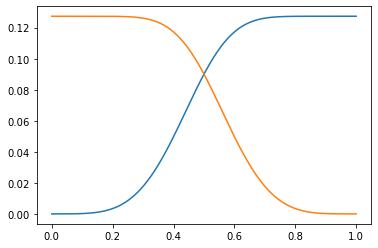

In [87]:
omega12, omega23 = pulses(times, tf, a0)

plt.plot(times, omega12/omega0)
plt.plot(times, omega23/omega0)

In [88]:
def solvePopulations(times, pulse12, pulse23):
    psi0 = basis(3, 0)

    if len(times) < 2:
        return np.abs(np.array([psi0])) ** 2
    
    H0 = Qobj([[0, 0, 0], [0, delta, 0], [0, 0, 0]])
    H12 = Qobj([[0, -1, 0], [-1, 0, 0], [0, 0, 0]])
    H23 = Qobj([[0, 0, 0], [0, 0, -1], [0, -1, 0]])

    H = [H0, [H12, pulse12], [H23, pulse23]]

    result = mesolve(H, psi0, times)

    psi_t = np.array(result.states).reshape((len(times), 3))
    return np.abs(psi_t) ** 2

In [89]:
population = solvePopulations(times, omega12, omega23)

Text(0, 0.5, 'P')

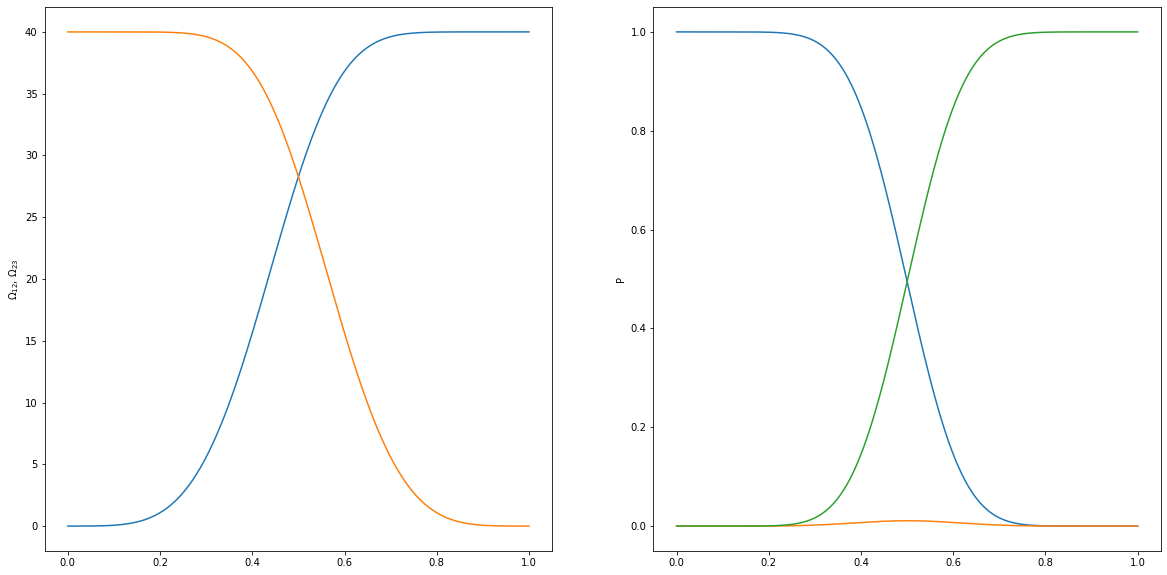

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

ax[0].plot(times, np.array([omega12, omega23]).T)
ax[0].set_ylabel(r'$\Omega_{12}$, $\Omega_{23}$')

ax[1].plot(times, population)
ax[1].set_ylabel("P")